In [22]:
pip install -U tensorboard_plugin_profile

Note: you may need to restart the kernel to use updated packages.


In [23]:
import tensorflow as tf
import numpy as np
from io import BytesIO
from skimage import io
import os, glob
import requests
import matplotlib.pyplot as plt
from PIL import Image
import tqdm
import cv2, time
import torch
from torch.nn import functional as F
from datetime import datetime
from packaging import version
import os

In [2]:
def preprocess_image(img_path, pre_pad=10, mod_scale=4):
    img = cv2.imread(img_path)
    h_input, w_input = img.shape[0:2] #gathered height and width of input image
    img = img.astype(np.float32)   # img: numpy
    if np.max(img) > 256:  # 16-bit image
        max_range = 65535
        print('\tInput is a 16-bit image')
    else:
        max_range = 255
    img = img / max_range #Normalization
    if len(img.shape) == 2:  # gray image
        img_mode = 'L'
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:  # RGBA image with alpha channel
        img_mode = 'RGBA'
        alpha = img[:, :, 3] 
        img = img[:, :, 0:3]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if alpha_upsampler == 'realesrgan':
            alpha = cv2.cvtColor(alpha, cv2.COLOR_GRAY2RGB)
    else:
        img_mode = 'RGB'
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = torch.from_numpy(np.transpose(img, (2, 0, 1))).float()
    img = img.unsqueeze(0).to("cuda") #moving the image to device
    img = F.pad(img, (0, pre_pad, 0, pre_pad), 'reflect')
    mod_pad_h, mod_pad_w = 0, 0
    _, _, h, w = img.size()
    #modification in height and width padding
    if (h % mod_scale != 0):
        mod_pad_h = (mod_scale - h % mod_scale)
    if (w % mod_scale != 0):
        mod_pad_w = (mod_scale - w % mod_scale)
    img = F.pad(img, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
    return img, mod_pad_h, mod_pad_w

def post_process(output, mod_pad_h, mod_pad_w, mod_scale=4, pre_pad=10):
    scale=1 # hardcoded for model_scale=4
    # remove extra pad
    if mod_scale is not None:
        _, _, h, w = output.size() #gathered height and width of the output image
        output = output[:, :, 0:h - mod_pad_h * scale, 0:w - mod_pad_w * scale] #padding of output image
    # remove prepad
    if pre_pad != 0:
        _, _, h, w = output.size()
        output = output[:, :, 0:h - pre_pad * scale, 0:w - pre_pad * scale]
    # unsqueeze to remove batch
    output = output.squeeze().float().cpu().clamp_(0, 1).numpy()
    # convert to channel last
    output = np.transpose(output, (1, 2, 0))
    output = (output * 255.0).round().astype(np.uint8) #normalization
    
    return output #finally returned the output


def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)
    
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [3]:
# Convert the model
saved_model_dir = "tf_model/"
data_path = "C:/Users/ayush/Rizzle/52_images_super_resolution_testing/converted_4_3"
print("loading model ...")
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
print("model loaded ...")

# a dozen steps are enough to calivrate
num_calibration_steps = 100

def representative_dataset_gen():
    for img_path in glob.glob(os.path.join(data_path, "*.jpg")):
        image,_,_ = preprocess_image(img_path)
        image = tf.convert_to_tensor(image.cpu().numpy())
        yield [image]

# post training integer quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = tf.lite.RepresentativeDataset(
    representative_dataset_gen)

# When this flag is used and an operation has no integer quantizable counterpart, the TensorFlow Lite Converter will throw an error.
# In such case commet it out
converter.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.post_training_quantize = True
print("optimizing model ...")
tflite_model = converter.convert()

loading model ...
model loaded ...
optimizing model ...


In [4]:
# Save the model.
with open('tflite_model/real_esrgan_android.tflite', 'wb') as f:
    f.write(tflite_model)

In [3]:

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='tflite_model/real_esrgan_android.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
print(input_shape)

[  1   3 192 192]


In [4]:
# Test the model on input data.
image_path = "C:/Users/ayush/Rizzle/video_super_resolution_speed_optimization/testing_with_real_esrgan/Real-ESRGAN/inputs/0014.jpg"


hr_image, mod_pad_h, mod_pad_w = preprocess_image(image_path)

In [5]:
hr_image = tf.convert_to_tensor(hr_image.cpu().numpy())

In [6]:
interpreter.set_tensor(input_details[0]['index'], hr_image)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output = interpreter.get_tensor(output_details[0]['index'])

In [7]:
sr = tf.squeeze(output, axis=0)
sr = tf.clip_by_value(sr, 0, 255)
sr = tf.round(sr)
sr = tf.cast(sr, tf.uint8)

# lr = tf.cast(tf.squeeze(lr, axis=0), tf.uint8)
# plt.figure(figsize = (1, 1))
# plt.title('LR')
# plt.imshow(lr.numpy());



In [8]:
sr = tf.transpose(sr)
sr.shape

TensorShape([768, 768, 3])

In [9]:
lr = tf.io.read_file(image_path)
lr = tf.image.decode_jpeg(lr)
lr = tf.expand_dims(lr, axis=0)
lr = tf.cast(lr, tf.float32)

In [10]:
lr = tf.squeeze(lr)
lr.shape

TensorShape([179, 179, 3])

In [11]:
type(sr)

tensorflow.python.framework.ops.EagerTensor

In [12]:
sr = torch.from_numpy(sr.numpy())

In [13]:
sr.shape

torch.Size([768, 768, 3])

In [14]:
b = torch.permute(sr, [2,0,1])
b.shape

torch.Size([3, 768, 768])

In [15]:
h = tf.convert_to_tensor(b.numpy())

In [16]:
h = tf.expand_dims(h, 0)
h.shape

TensorShape([1, 3, 768, 768])

In [17]:
f = sr = torch.from_numpy(h.numpy())

In [18]:
output = post_process(f, mod_pad_h, mod_pad_w)

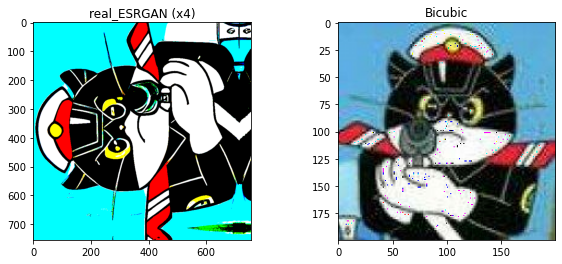

In [21]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)        
plt.title(f'real_ESRGAN (x4)')
plt.imshow(output);

bicubic = tf.image.resize(lr, [200, 200], tf.image.ResizeMethod.BICUBIC)
bicubic = tf.cast(bicubic, tf.uint8)
plt.subplot(1, 2, 2)   
plt.title('Bicubic')
plt.imshow(bicubic.numpy());